# The MacroConf dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# set matplotlib font sizes
SMALL_SIZE = 11
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc("font", size=MEDIUM_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

DPI = 600

from rdkit import Chem
from rdkit.Chem import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import rdDepictor, rdMolDraw2D

opts = Draw.DrawingOptions()
import mols2grid

# Draw.SetComicMode(opts)

In [2]:
df = pd.read_excel(
    "../data/external/22-09-2021_MacroConf-v2.1/MacroConf-data.xlsx"
)

In [3]:
df["SMILES"] = df["smiles"]
mols2grid.display(
    df,
    # RDKit's MolDrawOptions parameters
    fixedBondLength=60,
    # rename fields for the output document
    subset=["id", "img"],
    #                   tooltip=['id'],
    #                   MolDrawingOptions=opts,
    template="table",
    prerender=True,
)

MolGridWidget()

In [4]:
mols2grid.save(
    df,
    output="../reports/figures/MacroConf_molgrid.html",
    # RDKit's MolDrawOptions parameters
    fixedBondLength=60,
    # rename fields for the output document
    subset=["id", "img"],
    #                   tooltip=['id'],
    #                   MolDrawingOptions=opts,
    template="table",
    prerender=True,
    n_cols=10,
)

MolGridWidget()

```{note} The below figure is interactive. Hover over the molecule images to get more information about a specific molecule. Clicking on a molecule keeps this view open, e.g. to copy the paper reference. At the bottom (might have to scroll down slightly), the dataset can be sorted by different properties. To first see all natural cyclic peptides, one could sort by ‘is natural cyclic peptide’ in descending order.
```

In [5]:
mols2grid.display(
    df,
    # RDKit's MolDrawOptions parameters
    fixedBondLength=60,
    # rename fields for the output document
    subset=["id", "img"],
    tooltip=[
        "id",
        "sequence",
        "is natural cyclic peptide",
        "is unnatural cyclic peptide",
        "solvent",
        "paper-link",
        "type of NOE experiment",
    ],
    #                   MolDrawingOptions=opts,
    template="pages",
    size=(120, 90),
)

MolGridWidget()

In [6]:
smiles = df.smiles.to_list()
mols = [Chem.MolFromSmiles(x) for x in smiles]
ids = df.id.to_list()
ids = [str(x) for x in ids]
# Draw grid via Rdkit
test = Draw.MolsToGridImage(
    mols,
    molsPerRow=5,
    maxMols=200,
    legends=ids,
    subImgSize=(200, 200),
    useSVG=True,
)

# inspired by https://github.com/rdkit/UGM_2020/blob/master/Notebooks/Landrum_WhatsNew.ipynb
def show_mols(
    mols, mols_per_row=5, size=200, min_font_size=7, legends=[], file_name=""
):
    import math
    from IPython.display import SVG
    import cairosvg

    if legends and len(legends) < len(mols):
        print("legends is too short")
        return None

    mols_per_row = min(len(mols), mols_per_row)
    rows = math.ceil(len(mols) / mols_per_row)
    d2d = rdMolDraw2D.MolDraw2DSVG(
        mols_per_row * size, rows * size, size, size
    )
    d2d.drawOptions().minFontSize = min_font_size
    d2d.drawOptions().bondLineWidth = 1
    if legends:
        d2d.DrawMolecules(mols, legends=legends)
    else:
        d2d.DrawMolecules(mols)
    d2d.FinishDrawing()

    if file_name:
        with open("d2d.svg", "w") as f:
            f.write(d2d.GetDrawingText())
            if "pdf" in file_name:
                cairosvg.svg2pdf(url="d2d.svg", write_to=file_name)
            else:
                cairosvg.svg2png(url="d2d.svg", write_to=file_name)
            os.remove("d2d.svg")

    return SVG(d2d.GetDrawingText())

In [7]:
show_mols(mols, legends=ids, size=250)

Text(-0.1, 1.15, 'A')

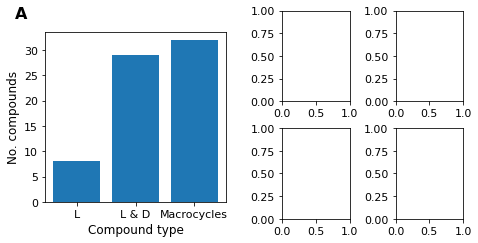

In [8]:
components = ["L", "L & D", "Macrocycles"]
natural = df["is natural cyclic peptide"].sum()  # / len(df)
unnatural = df["is unnatural cyclic peptide"].sum()  # / len(df)
mc = len(df) - (natural + unnatural)
compounds = [natural, unnatural, mc]

fig = plt.figure(constrained_layout=True, figsize=(3.2677 * 2, 3.2677))
subfigs = fig.subfigures(1, 2, wspace=0.07)

# Create left and right axes
axsLeft = subfigs[0].subplots(1, 1)
axsRight = subfigs[1].subplots(2, 2)

x_pos = np.arange(len(compounds))

# fig, ax = plt.subplots(1,1)
axsLeft.bar(x_pos, compounds, align="center")
axsLeft.set_xticks(x_pos, labels=components)
# axsLeft.invert_xaxis()  # labels read top-to-bottom
axsLeft.set_ylabel("No. compounds")
axsLeft.set_xlabel("Compound type")
# axsLeft.set_title('Compound types in the MacroConf dataset')
axsLeft.text(
    -0.1,
    1.15,
    "A",
    transform=axsLeft.transAxes,
    fontsize=16,
    fontweight="bold",
    va="top",
    ha="right",
)

In [9]:
def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])

In [10]:
# fig, axs = plt.subplots(2,2)
# sequence length
seq_lengths = np.array(df["backbone size"].tolist())
bins = np.arange(seq_lengths.min(), seq_lengths.max() + 1.5) - 0.5
axsRight[0, 0].hist(seq_lengths, bins, rwidth=0.8)
axsRight[0, 0].set_xticks(bins[::2] + 0.5)
# axsRight[0,0].set_title("Sequence length")
axsRight[0, 0].set_xlabel("Sequence length")

# solvents
solvents = df["solvent data"].tolist()
solvents = flatten([s.split(",") for s in solvents])
axsRight[0, 1].hist(solvents, rwidth=0.8)
axsRight[0, 1].set_title("Solvents")
for tick in axsRight[0, 1].get_xticklabels():
    tick.set_rotation(45)

# NOE quality
noe_quality = df["NOE quality"].replace([0, 5], ["low", "high"]).tolist()
labels, counts = np.unique(noe_quality, return_counts=True)
axsRight[1, 0].bar(labels, counts, align="center", width=0.6)
axsRight[1, 0].set_xticks(labels)

# axsRight[1,0].hist(noe_quality, rwidth=0.8)
axsRight[1, 0].set_xlabel("NOE quality")

# No. of NOEs
noe_no = [str(i) for i in df["No NOEs"].tolist()]
noe_no = flatten([s.split(",") for s in noe_no])
noe_no = [int(s) for s in noe_no]
axsRight[1, 1].hist(noe_no, rwidth=0.8)
# axsRight[1,1].set_title("No. of NOEs")
axsRight[1, 1].set_xlabel("No. NOEs")
# fig.tight_layout()

labels = ["B", "C", "D", "E"]
for ax, label in zip(axsRight.flatten(), labels):
    ax.text(
        -0.1,
        1.35,
        label,
        transform=ax.transAxes,
        fontsize=16,
        fontweight="bold",
        va="top",
        ha="right",
    )
fig.savefig("../reports/figures/Macroconf_dataset.pdf", dpi=DPI)

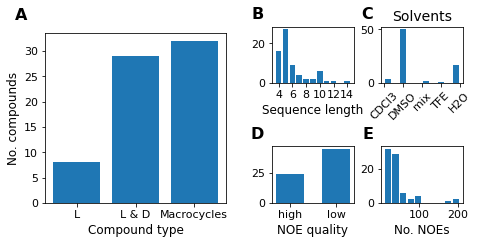

In [11]:
# fig.tight_layout()
fig